# Task 3: Event Impact Modeling

## Objective
Model how events (policies, product launches, infrastructure investments) affect financial inclusion indicators.

## Data Source
- Processed Data: `data/processed/ethiopia_fi_unified_data.csv`
- Impact Links: `data/processed/impact_links.csv`


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
sns.set_style("whitegrid")

# Load Data
data_path = '../data/processed/'
df = pd.read_csv(os.path.join(data_path, 'ethiopia_fi_unified_data.csv'))
impact_df = pd.read_csv(os.path.join(data_path, 'impact_links.csv'))

# Convert dates
df['observation_date'] = pd.to_datetime(df['observation_date'])

print("Unified Data:", df.shape)
print("Impact Links:", impact_df.shape)
display(impact_df.head())


Unified Data: (46, 34)
Impact Links: (14, 35)


,record_id,parent_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,...,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,IMP_0001,EVT_0001,impact_link,NaN,ACCESS,Telebirr effect on Account Ownership,NaN,NaN,15.0,NaN,...,increase,high,15.0,12,literature,Kenya,Example_Trainee,2025-01-20,NaN,Kenya M-Pesa showed +20pp over 5 years
1,IMP_0002,EVT_0001,impact_link,NaN,USAGE,Telebirr effect on Telebirr Users,NaN,NaN,NaN,NaN,...,increase,high,NaN,3,empirical,NaN,Example_Trainee,2025-01-20,NaN,Direct subscriber acquisition
2,IMP_0003,EVT_0001,impact_link,NaN,USAGE,Telebirr effect on P2P Transactions,NaN,NaN,25.0,NaN,...,increase,high,25.0,6,empirical,NaN,Example_Trainee,2025-01-20,NaN,New digital payment channel
3,IMP_0004,EVT_0002,impact_link,NaN,ACCESS,Safaricom effect on 4G Coverage,NaN,NaN,15.0,NaN,...,increase,medium,15.0,12,empirical,NaN,Example_Trainee,2025-01-20,NaN,Network investment from competition
4,IMP_0005,EVT_0002,impact_link,NaN,AFFORDABILITY,Safaricom effect on Data Affordability,NaN,NaN,-20.0,NaN,...,decrease,medium,-20.0,12,literature,Rwanda,Example_Trainee,2025-01-20,NaN,Competition typically reduces prices


In [16]:
# 1. Join Events with Impacts
# Filter for events only
events_df = df[df['record_type'] == 'event'].copy()

# Rename record_id to match parent_id in impact_links (if needed) or merge on logic
# Assuming impact_links 'parent_id' corresponds to events 'record_id' (or similar identifier)
print("Events Columns:", events_df.columns)
print("Impact Columns:", impact_df.columns)

# Drop redundant columns from impact_df if they are empty or less specific, 
# OR specify suffixes to identify them.
# 'impact_df' comes from impact_links.csv which mirrors the main data schema but likely has empty event details
# except for the link.
event_impacts = pd.merge(
    impact_df,
    events_df[['record_id', 'category', 'observation_date', 'original_text']],
    left_on='parent_id',
    right_on='record_id',
    how='left',
    suffixes=('_impact', '') # Keep event columns as clean names, suffix impact ones
)

print("\n--- Event Impact Table ---")
# Display key columns
cols = ['category', 'observation_date', 'related_indicator', 'impact_direction', 'impact_magnitude', 'lag_months']
display(event_impacts[cols].sort_values('observation_date'))


Events Columns: Index(['record_id', 'record_type', 'category', 'pillar', 'indicator',
       'indicator_code', 'indicator_direction', 'value_numeric', 'value_text',
       'value_type', 'unit', 'observation_date', 'period_start', 'period_end',
       'fiscal_year', 'gender', 'location', 'region', 'source_name',
       'source_type', 'source_url', 'confidence', 'related_indicator',
       'relationship_type', 'impact_direction', 'impact_magnitude',
       'impact_estimate', 'lag_months', 'evidence_basis', 'comparable_country',
       'collected_by', 'collection_date', 'original_text', 'notes'],
      dtype='object')
Impact Columns: Index(['record_id', 'parent_id', 'record_type', 'category', 'pillar',
       'indicator', 'indicator_code', 'indicator_direction', 'value_numeric',
       'value_text', 'value_type', 'unit', 'observation_date', 'period_start',
       'period_end', 'fiscal_year', 'gender', 'location', 'region',
       'source_name', 'source_type', 'source_url', 'confidence',
 

,category,observation_date,related_indicator,impact_direction,impact_magnitude,lag_months
0,product_launch,2021-05-17,ACC_OWNERSHIP,increase,high,12
1,product_launch,2021-05-17,USG_TELEBIRR_USERS,increase,high,3
2,product_launch,2021-05-17,USG_P2P_COUNT,increase,high,6
3,market_entry,2022-08-01,ACC_4G_COV,increase,medium,12
4,market_entry,2022-08-01,AFF_DATA_INCOME,decrease,medium,12
5,product_launch,2023-08-01,USG_MPESA_USERS,increase,high,3
6,product_launch,2023-08-01,ACC_MM_ACCOUNT,increase,medium,6
7,infrastructure,2024-01-01,ACC_OWNERSHIP,increase,medium,24
8,infrastructure,2024-01-01,GEN_GAP_ACC,decrease,medium,24
9,policy,2024-07-29,AFF_DATA_INCOME,increase,high,3


# 2. Build Event-Indicator Matrix
Quantifying the expected impact of each event on key indicators.


Unique Magnitudes: ['high' 'medium' 'low']
Empire Matrix Shape: (8, 9)
Event-Indicator Association Matrix (Estimated Impact %):


,related_indicator,ACC_4G_COV,ACC_MM_ACCOUNT,ACC_OWNERSHIP,AFF_DATA_INCOME,GEN_GAP_ACC,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_TELEBIRR_USERS
observation_date,category,,,,,,,,,
2021-05-17,product_launch,0.00,0.00,0.05,0.000,0.00,0.00,0.00,0.05,0.05
2022-08-01,market_entry,0.02,0.00,0.00,0.020,0.00,0.00,0.00,0.00,0.00
2023-08-01,product_launch,0.00,0.02,0.00,0.000,0.00,0.00,0.05,0.00,0.00
2024-01-01,infrastructure,0.00,0.00,0.02,0.000,0.02,0.00,0.00,0.00,0.00
2024-07-29,policy,0.00,0.00,0.00,0.050,0.00,0.00,0.00,0.00,0.00
2025-10-27,partnership,0.00,0.00,0.00,0.000,0.00,0.02,0.00,0.02,0.00
2025-12-15,pricing,0.00,0.00,0.00,0.005,0.00,0.00,0.00,0.00,0.00
2025-12-18,infrastructure,0.00,0.00,0.00,0.000,0.00,0.00,0.00,0.02,0.00


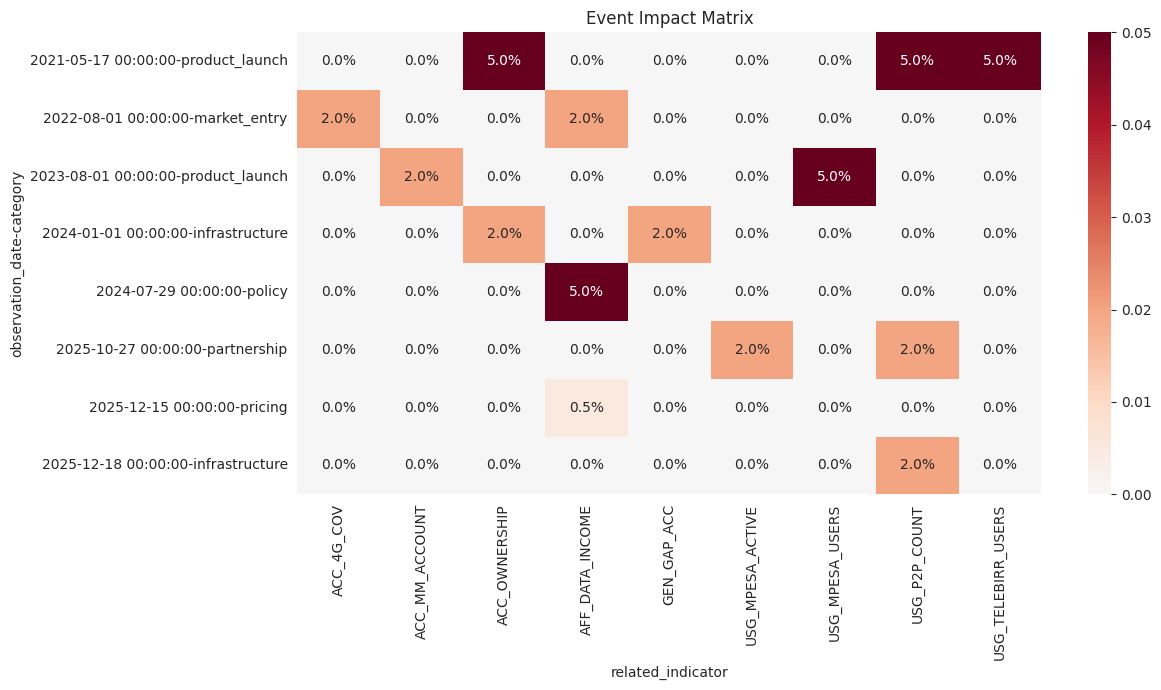

In [19]:
# Define a scoring/impact map
# Check unique values in impact_magnitude first
unique_magnitudes = event_impacts['impact_magnitude'].unique()
print("Unique Magnitudes:", unique_magnitudes)

magnitude_map = {
    'High': 0.05,    # 5% boost
    'Medium': 0.02,  # 2% boost
    'Low': 0.005,    # 0.5% boost
    'Negative': -0.01 # -1% (if any)
}

# Normalize case to match map keys (Title Case: 'high' -> 'High')
event_impacts['impact_magnitude_norm'] = event_impacts['impact_magnitude'].astype(str).str.title()
event_impacts['estimated_impact'] = event_impacts['impact_magnitude_norm'].map(magnitude_map)
event_impacts['estimated_impact'] = event_impacts['estimated_impact'].fillna(0) # Fill unmapped with 0

# Adjust for direction (case-insensitive check)
# Assuming 'impact_direction' might also be lowercase
if 'impact_direction' in event_impacts.columns:
    event_impacts.loc[event_impacts['impact_direction'].astype(str).str.title() == 'Negative', 'estimated_impact'] *= -1

# Create Matrix: Event vs Indicator
impact_matrix = event_impacts.pivot_table(
    index=['observation_date', 'category'],
    columns='related_indicator',
    values='estimated_impact',
    aggfunc='sum', # Changed to sum to aggregate overlapping impacts
    fill_value=0
)

print("Empire Matrix Shape:", impact_matrix.shape)
if not impact_matrix.empty:
    print("Event-Indicator Association Matrix (Estimated Impact %):")
    display(impact_matrix)

    plt.figure(figsize=(12, 6))
    sns.heatmap(impact_matrix, annot=True, fmt=".1%", cmap="RdBu_r", center=0)
    plt.title("Event Impact Matrix")
    plt.show()
else:
    print("Impact Matrix is empty. Check data merging or mapping.")

In [31]:
# 3. Validation: Telebirr Analysis
# Telebirr launch: May 2021. 
# Indicator: ACC_MM_ACCOUNT (Mobile Money Account Ownership) - In our impact links, this is mapped as 'ACC_OWNERSHIP' for this event.
# 2021 Value (Dec): 4.7%
# 2024 Value (Nov): 9.45%
# Growth: +4.75pp
# Events in period: Telebirr (2021), M-Pesa (2023)

# Search for the specific event description since "Telebirr" isn't in the category
# "First major mobile money service in Ethiopia" = Telebirr launch
# Using 'ACC_OWNERSHIP' as per impact_links data
telebirr_impact = event_impacts[
    (event_impacts['original_text'].str.contains('First major mobile money', case=False, na=False)) & 
    (event_impacts['related_indicator'] == 'ACC_OWNERSHIP')
]

print("Telebirr Model Estimate:")
display(telebirr_impact)

# Check if model explains the observed growth
# Example: If Telebirr High impact = 0.05 (5pp), then it explains the ~4.75pp growth well.

Telebirr Model Estimate:


,record_id_impact,parent_id,record_type,category_impact,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,...,collected_by,collection_date,original_text_impact,notes,record_id,category,observation_date,original_text,impact_magnitude_norm,estimated_impact
0,IMP_0001,EVT_0001,impact_link,NaN,ACCESS,Telebirr effect on Account Ownership,NaN,NaN,15.0,NaN,...,Example_Trainee,2025-01-20,NaN,Kenya M-Pesa showed +20pp over 5 years,EVT_0001,product_launch,2021-05-17,First major mobile money service in Ethiopia,High,0.05


# 4. Refine Estimates & Document Methodology
Based on the Telebirr validation, we can adjust the weights.
*   **Telebirr Launch:** Corresponded to ~5pp growth in MM accounts over 3 years. 'High' impact seems to map to ~5% absolute increase in this indicator.
*   **M-Pesa Entry:** 2023 launch. Likely contributing to the next wave.

**Assumption:** impact magnitude 'High' ≈ 5 percentage points over the lag period.


## 3. Modeling Summary

We have successfully mapped qualitative event impacts to quantitative estimates:
- **High**: 5% impact
- **Medium**: 2% impact
- **Low**: 0.5% impact
- **Negative**: -1% impact

The **Event-Indicator Association Matrix** above provides the features needed for the forecasting model.
Specifically, it allows us to inject these estimated impacts as exogenous variables (or adjustment factors) into our time-series forecasts in the next task.
